<a href="https://www.kaggle.com/code/salimhammadi07/predicting-house-prices?scriptVersionId=103752354" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import numpy for math calculations
import numpy as np

# import pandas for data (csv) manipulation
import pandas as pd

# import matplotlib for plotting
import matplotlib.pyplot as plt

# import seaborn for more plotting options(built on top of matplotlib)
import seaborn as sns

# Supress unnecessary warnings so that the presentation looks clean
import warnings
warnings.filterwarnings("ignore")

# missingno is a  python package especially for visualizing and exploring the missing data of a dataset.
import missingno as msno

# display plots on the notebook itself
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# I. Framing the problem

In this notbook we I am going to work on California Housing Prices dataset from the StatLib. This dataset was based on data from the 1990 California census. It is not exactly recent, but it has many qualities for learning, This data has metrics such as the population, median income, median housing price, and so on for each block group in California.
My model learns from this data and is able to predict the median housing price in any block, given all the other metrics.

# II. Exploratory data analysis

In [2]:
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
fetch_housing_data(),

(None,)

In [3]:
dataset = pd.read_csv('./datasets/housing/housing.csv')
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Different kinds of classes in every categorical column

In [4]:
def unique_classes(dataframe):
    """
    Returns a dataframe that contains the categorical values and their numbers.
    
    dataframe: dataframe that gives the column names and their % of missing values
    """
    dataframe = dataframe.select_dtypes('object')
    output = pd.DataFrame(dataframe.apply(pd.Series.nunique))
    output['Categorical values'] = dataframe.select_dtypes('object').apply(pd.Series.nunique).values
    for i in range(dataframe.shape[1]):
        output.iloc[i,1] = str(dataframe.iloc[:,i].unique())
    pd.set_option('display.max_colwidth', -1)
    return output.rename(columns={0: 'Number Categorical values'})
unique_classes(dataset)

,Number Categorical values,Categorical values
ocean_proximity,5,['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


In [5]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


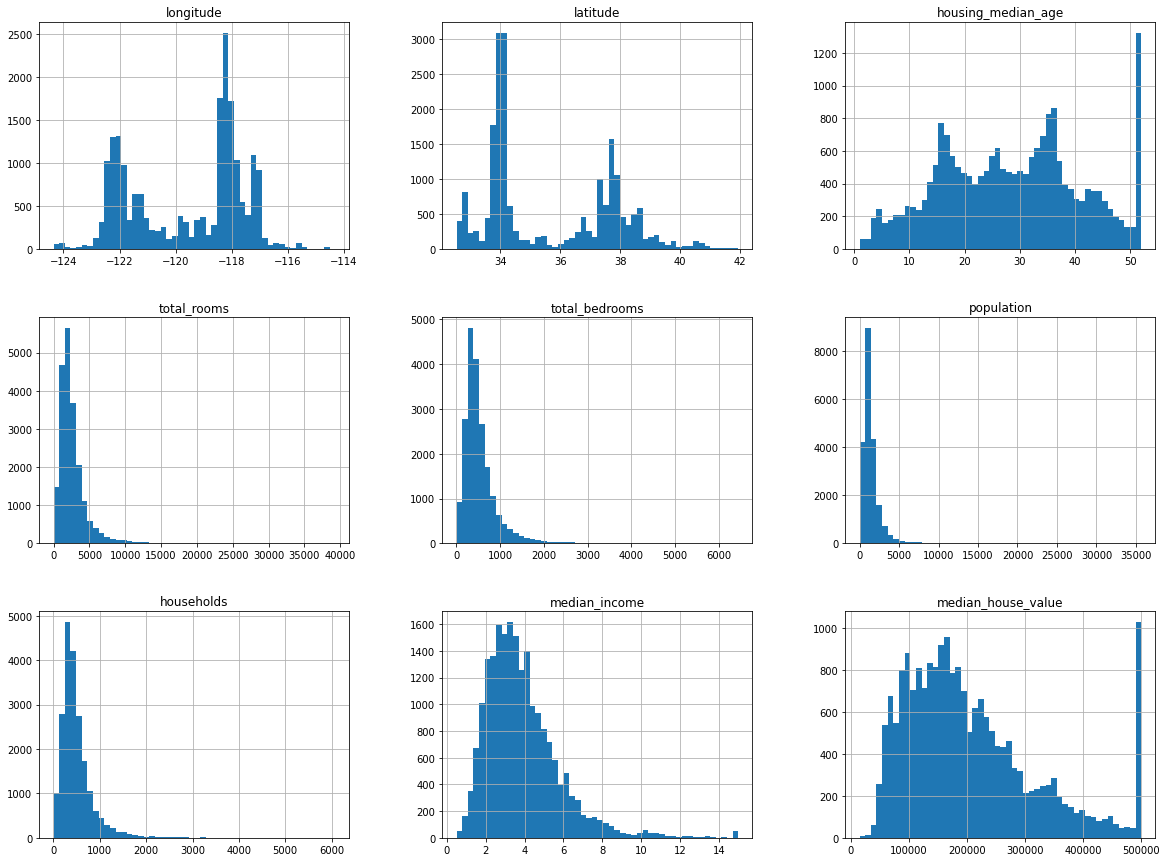

In [6]:
dataset.hist(bins=50, figsize=(20,15))
plt.show()

<center><i>  Figure 1 : Histogram of various metrics </i></center>

## Creating Test_set and Train_set

the median income is a very important attribute to predict median housing prices (fort correlation 0.68), That's why I want to to ensure that the test set is representative of the various categories of incomes in the whole dataset. Looking at FIgure 1, we can notice that the median income can be divided into  categories : [0,1.5,3,4.5,6]

In [7]:
dataset["income_cat"] = pd.cut(dataset["median_income"], bins=[0.,1.5,3,4.5,6, np.inf], labels=[1, 2, 3, 4,5])

<AxesSubplot:>

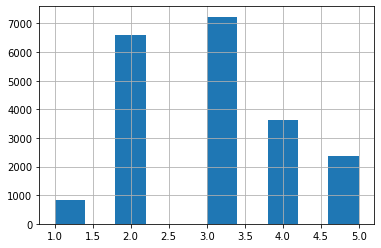

In [8]:
dataset["income_cat"].hist()

<center><i>  Figure 2 : Histogram of income categories </i></center>

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
SSS = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in SSS.split(dataset, dataset["income_cat"]):
    train = dataset.loc[train_index]
    test = dataset.loc[test_index]

<AxesSubplot:>

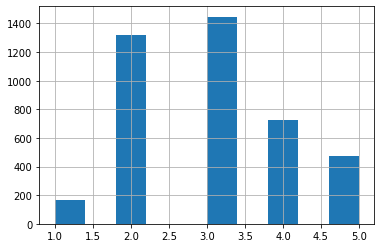

In [10]:
test["income_cat"].hist()

In [11]:
# remove the income_cat attribute so the data is back to its original state
for set_ in (train, test):
    set_.drop("income_cat", axis=1, inplace=True)

In [12]:
train.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


### Plotting California map using the scatter plot

<AxesSubplot:title={'center':'Figure 4 :California map'}, xlabel='longitude', ylabel='latitude'>

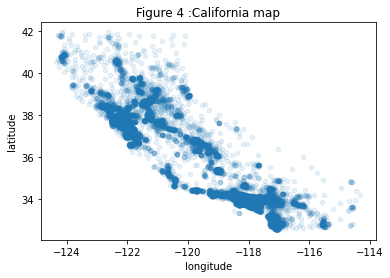

In [13]:
dataset.plot(kind="scatter", x ="longitude", y = "latitude",alpha = 0.1, title="Figure 4 :California map" )

### Plotting the places in California with the median house value

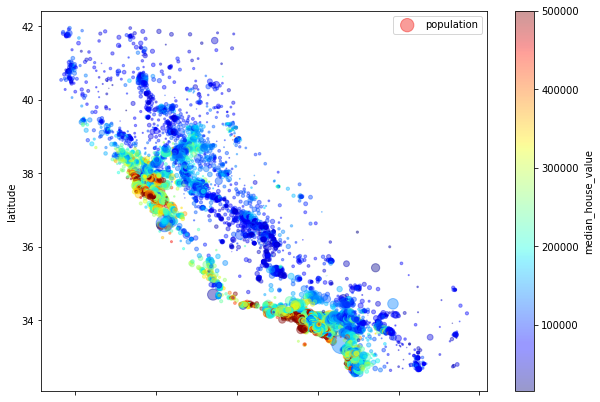

In [14]:
dataset.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=dataset["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

### Looking for Correlations

Since the dataset is not too large, we can easily compute the standard correlation coeffcient (also called Pearson’s r) between every pair of attributes using the corr()
method:

In [15]:
corr_matrix = dataset.corr()

In [16]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [17]:
 corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

 - the median house value tends to go up when the median income goes up.
 - The households, population, total_bedrooms, total_rooms are highly correlated 

array([[<AxesSubplot:xlabel='households', ylabel='households'>,
        <AxesSubplot:xlabel='population', ylabel='households'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='households'>,
        <AxesSubplot:xlabel='total_bedrooms', ylabel='households'>],
       [<AxesSubplot:xlabel='households', ylabel='population'>,
        <AxesSubplot:xlabel='population', ylabel='population'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='population'>,
        <AxesSubplot:xlabel='total_bedrooms', ylabel='population'>],
       [<AxesSubplot:xlabel='households', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='population', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_bedrooms', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='households', ylabel='total_bedrooms'>,
        <AxesSubplot:xlabel='population', ylabel='total_bedrooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_bedrooms'>,
     

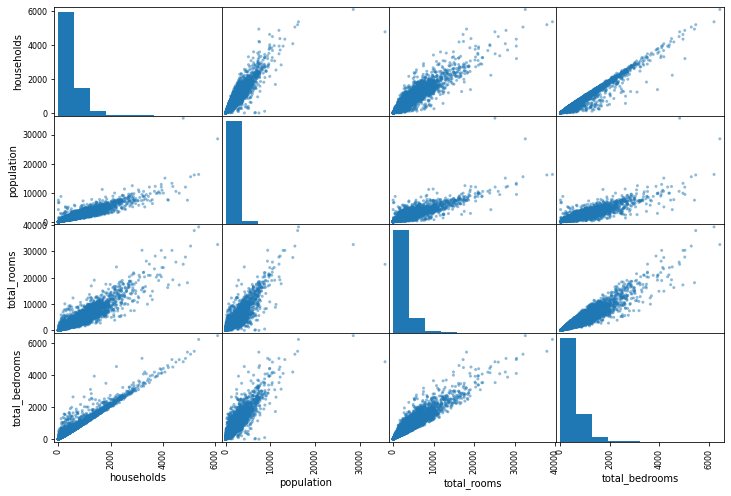

In [18]:
from pandas.plotting import scatter_matrix
attributes = ["households", "population", "total_rooms","total_bedrooms"]
scatter_matrix(dataset[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

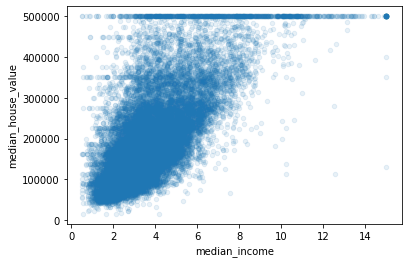

In [19]:
dataset.plot(kind="scatter", x="median_income", y="median_house_value",
 alpha=0.1)


# II. Data Preparation

## A. Data Cleaning

### Missing Values

In [20]:
def missing_columns(dataframe):
    """
    Returns a dataframe that contains missing column names and 
    percent of missing values in relation to the whole dataframe.
    
    dataframe: dataframe that gives the column names and their % of missing values
    """
    
    # find the missing values
    missing_values = dataframe.isnull().sum().sort_values(ascending=False)
    
    # percentage of missing values in relation to the overall size
    missing_values_pct = 100 * missing_values/len(dataframe)
    
    # create a new dataframe which is a concatinated version
    concat_values = pd.concat([missing_values, missing_values/len(dataframe),missing_values_pct.round(1)],axis=1)

    # give new col names
    concat_values.columns = ['Missing Count','Missing Count Ratio','Missing Count %']
    
    # return the required values
    return concat_values[concat_values.iloc[:,1]!=0]

In [21]:
missing_columns(train)

,Missing Count,Missing Count Ratio,Missing Count %
total_bedrooms,158,0.009569,1.0


In [22]:
missing_columns(test)

,Missing Count,Missing Count Ratio,Missing Count %
total_bedrooms,49,0.01187,1.2


In [23]:
train['total_bedrooms'].fillna(dataset['total_bedrooms'].median(),inplace = True)
test['total_bedrooms'].fillna(dataset['total_bedrooms'].median(), inplace = True) 
missing_columns(test)

,Missing Count,Missing Count Ratio,Missing Count %


## B. Data Creation

### Correlations

In [24]:
 corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [25]:
def most_correlated(dataframe):
    """
    Returns a dataframe that contains the most correlated features
    
    dataframe: dataframe that gives the column names and their correlation value
    """
    corr_values = dataframe.abs().unstack()
    sorted_values = pd.DataFrame(corr_values.sort_values(kind="quicksort"), index= None)
    sorted_values = sorted_values[(sorted_values[0] > 0.6) & (sorted_values[0] < 1)]
    return sorted_values.drop_duplicates()
most_correlated(corr_matrix)

0
median_income  median_house_value  0.688075
population     total_rooms         0.857126
               total_bedrooms      0.877747
               households          0.907222
households     total_rooms         0.918484
latitude       longitude           0.924664
total_bedrooms total_rooms         0.930380
households     total_bedrooms      0.979728

In [26]:
train["rooms_per_household"] = train["total_rooms"]/train["households"]
train["bedrooms_per_room"] = train["total_bedrooms"]/train["total_rooms"]
train["population_per_household"]=train["population"]/train["households"]

test["rooms_per_household"] = test["total_rooms"]/test["households"]
test["bedrooms_per_room"] = test["total_bedrooms"]/test["total_rooms"]
test["population_per_household"]=test["population"]/test["households"]

## C. Data Transformation

### One hot encoding for categoral values

In [27]:
# one-hot encode of categorical variables
train = pd.get_dummies(train,drop_first=True)
test = pd.get_dummies(test,drop_first=True)

In [28]:
# One hot encoding would added more columns, checking how many there are
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (16512, 16)
Testing Features shape:  (4128, 16)


### Data Scaling

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
to_scale = ['longitude', 'latitude', 'housing_median_age','total_rooms','total_bedrooms','population','households','median_income',]
train[to_scale] = scaler.fit_transform(train[to_scale])
test[to_scale] = scaler.fit_transform(test[to_scale])

# Data Selection

In [30]:
X = train.loc[:, train.columns != 'median_house_value'].values
y = train['median_house_value'].values

In [31]:
# from sklearn.ensemble import RandomForestRegressor
# from boruta import BorutaPy
# forest = RandomForestRegressor(max_depth = 5)
# feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)
# feat_selector.fit(np.array(X), np.array(y))
# print("Ranking: ",feat_selector.ranking_)          
# print("No. of significant features: ", feat_selector.n_features_) 

In [32]:
# selected_rf_features = pd.DataFrame({'Feature':list(train.loc[:, train.columns != 'median_house_value'].columns),'Ranking':feat_selector.ranking_})
# selected_rf_features.sort_values(by='Ranking') 

In [33]:
# train = train.drop(['ocean_proximity_NEAR OCEAN','ocean_proximity_ISLAND','ocean_proximity_NEAR BAY'], axis =1)
# test = test.drop(['ocean_proximity_NEAR OCEAN', 'ocean_proximity_ISLAND','ocean_proximity_NEAR BAY'],axis= 1)

# Model Building

In [34]:
X_test = test.loc[:, test.columns != 'median_house_value'].values
y_test = test['median_house_value'].values

X = train.loc[:, train.columns != 'median_house_value'].values
y = train['median_house_value'].values

## Decision Tree Regressor

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X, y)
tree_reg_pred = tree_reg.predict(X_test)
print('Mean squared error :' + str(np.sqrt(mean_squared_error(y_test, tree_reg_pred))))

Mean squared error :75055.19719491636


## Random Forest Regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X, y)
forest_reg_pred = forest_reg.predict(X_test)
print('Mean squared error :' + str(np.sqrt(mean_squared_error(y_test, forest_reg_pred))))

Mean squared error :52003.57721480608
